__File: srg_potentials_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     August 28, 2019__

This notebook creates several figures showing SRG-evolved NN potentials. Each function creates and saves a figure to the __Figures/SRG_potentials__ folder. Below is an outline of each function:
* potential_contours - Plots contours of an SRG-evolving potential in $\lambda$.
* potential_slices - Plots the diagonal or far off-diagonal matrix elements of an SRG-evolving potential in $\lambda$. <font color=red>Work in progress.</font>

__Revision history:<br/>__
* September 6, 2019 - Generalized potential_diagonals and potential_off_diagonals functions to potential_slices function.
* September 10, 2019 - Changed potential_contours function to label either the potential, SRG generator, or both.

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# Scripts made by A.T.
from Figures import figures_functions as ff
from Potentials.vsrg_macos import load_save_potentials as lp

__Plotting functions__

In [2]:
def potential_contours(kvnn, channel, kmax, kmid, ntot, generator, lambda_array, label='both'):
    """
    Plots NN potential contours [fm] with respect to momentum [fm^-1] SRG-evolving in lambda from 6 to 1.5 fm^-1.
    Must specify details of the SRG-evolved potential, hence the arguments kvnn, channel, etc. This is a 1 x 4
    sub-plots figure.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values in units fm^-1.
    label : str, optional
        Option on what label to add to the figure: label either the NN potential, the SRG generator, or both.
        Default value is 'both'; other values are 'potential' or 'generator'.

    Saves
    -----
    file_name = potential_contours_ with an extension based off the given arguments. For example,
                potential_contours_kvnn6_3S1_Wegner_both.
    file_type = .pdf
    
    """
    
    
    # --- Set-up --- #
    
    # Load momentum for interpolation
    k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Limits of axes on contours (units are fm^-1)
    axes_max = 4.0
    
    # Specifications of x and y axes
    # Step-size in labeling tick marks
    axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    
    # Limits of colorbar (units are fm) - depends on partial wave channel!
    if channel in ['1S0', '3S1']:
        mx = 1.0
        mn = -1.0
    elif channel in ['1P1']:
        mx = 0.5
        mn = -0.5
    else:
        mx = 1.0
        mn = -1.0
    
    # Labels
    axes_label = 'k [fm' + r'$^{-1}$' + ']'
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    colorbar_label = '[fm]'
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    lambda_label_size = 17
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18
    
    # Location of labels
    lambda_label_location = 'lower left'
    
    # Specifications for potential and generator labels
    if label in ['potential', 'both']:
        potential_label = ff.kvnn_label_conversion(kvnn)
        potential_label_size = 17
        potential_label_location = 'upper right'
    if label in ['generator', 'both']:
        generator_label = ff.generator_label_conversion(generator)
        generator_label_size = 17
        generator_label_location = 'upper right'

    # Color scheme for contour plots
    color_style = 'jet'
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # (width, height) - extra width for colorbar
    
    # File name of figure
    # This reads 'potential_contours_kvnn_number_channel_generator_label'
    file_name = 'potential_contours_kvnn%d_%s_%s_%s' % (kvnn, channel, generator, label)

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot contours --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over lambda values keeping track of sub-plot number i
    i = 0
    for lamb in lambda_array:
        
        # Load evolved potential
        if generator == 'Block-diag':
            V_evolved = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lambda_array[-1],
                                          lambda_bd=lamb)
        else:
            V_evolved = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
        
        # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
        # interpolated)
        k_array_int, V_evolved_int = ff.interpolate_matrix(k_array, V_evolved, axes_max)
        
        # Add sub-plot to figure (for last sub-plot, must specify colorbar c)
        if i != ( len(lambda_array) - 1):
            axs[i].pcolormesh(k_array_int, k_array_int, V_evolved_int, cmap=color_style, vmin=mn, vmax=mx,
                              rasterized=True)
        else:
            c = axs[i].pcolormesh(k_array_int, k_array_int, V_evolved_int, cmap=color_style, vmin=mn, vmax=mx,
                                  rasterized=True)
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(axes_ticks)
        axs[i].xaxis.set_ticklabels(axes_ticks)
        # Specify axes limits
        axs[i].set_xlim( (0, axes_max) )
        axs[i].set_ylim( (0, axes_max) )
        # Position of x-axis label and tick marks
        axs[i].xaxis.set_label_position('top')
        axs[i].xaxis.tick_top()
        axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)
        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if i != ( len(lambda_array) - 1 ):
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
        # Set axes labels
        axs[i].set_xlabel(axes_label, fontsize=axes_label_size)
        # Only specify y axis tick marks and set label for 1st sub-plot
        if i == 0:
            axs[i].yaxis.set_ticks(axes_ticks)
            axs[i].yaxis.set_ticklabels(axes_ticks)
            axs[i].set_ylabel(axes_label, fontsize=axes_label_size)
            # Add potential label as anchored text
            if label == 'both':
                potential_anchored_text = AnchoredText(potential_label, prop=dict(size=potential_label_size),
                                                       loc=potential_label_location)
                axs[i].add_artist(potential_anchored_text)
        # Add lambda label as anchored text
        lambda_anchored_text = AnchoredText(lambda_label % lambda_array[i], prop=dict(size=lambda_label_size),
                                            loc=lambda_label_location)
        axs[i].add_artist(lambda_anchored_text)
        # Add potential and/or generator label as anchored text
        if i == ( len(lambda_array) - 1 ):
            # Just the potential label
            if label == 'potential':
                potential_anchored_text = AnchoredText(potential_label, prop=dict(size=potential_label_size),
                                                       loc=potential_label_location)
                axs[i].add_artist(potential_anchored_text)
            # Add the generator label
            else:
                generator_anchored_text = AnchoredText(generator_label, prop=dict(size=generator_label_size),
                                                       loc=generator_label_location)
                axs[i].add_artist(generator_anchored_text)
            
        i += 1
    
    
    # --- Set figure specifications and save --- #
    
    # Invert y-axis
    plt.gca().invert_yaxis()
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    # Adjust for colorbar space
    f.subplots_adjust(right=0.8)
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
    # Add colorbar and set tick size
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_potentials')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [3]:
def potential_slices(line, channel, lambda_array, *potentials):
    """
    Plots NN potential contours [fm] with respect to momentum [fm^-1] SRG-evolving in lambda isolating either the
    diagonal or far off-diagonal matrix elements. Must specify the partial wave channel, lambda values, and each 
    SRG-evolved potential of interest. Here, we compare the Wegner generator at the different lambda values to the
    block-diagonal generator at Lambda_BD = lambda (Wegner) and fixing lambda (block diagonal) to the last value of
    lambda in lambda_array.
    
    Parameters
    ----------
    line : str
        The slice of V(k, k') 'diag' or 'off-diag'
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    lambda_array : 1-D ndarray
        Lambda evolution values in units fm^-1. These values will also be used as Lambda_BD values for the block-
        diagonal generator.
    *potentials : tuple
        Specifications for SRG-evolving NN potentials in the format (kvnn, kmax, kmid, ntot) where kvnn (int) is the
        number specifying the potential, kmax (float) is the maximum value in the momentum mesh, kmid (float) is the
        mid-point value in the mesh, and ntot (int) is the number of points in the mesh. For example,
        (10, 30.0, 4.0, 120) corresponds to the default Entem-Machleidt N3LO potential.

    Saves
    -----
    file_name = potential_ with an extension based off the given arguments. For example,
                potential_diags_3S1_kvnns_10_106_222_lamb1,0.
    file_type = .pdf
    
    """
    
    
    # Check that at least one potential was provided
    if not potentials: 
        print('At least one SRG-evolved potential must be specified.')
        return None

    
    # --- Set-up --- #
    
    # This null kvnn is used to assign colors to each evolved potential in the figure
    #kvnn_list = []
    
    # Limits of x and y axes (dependent on line)
    xlim = [0.0, 4.0]
    ylim = [-4.5, 2.0]
    
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    if line == 'diag':
        y_label = r'$V_{\lambda}(k, k)$' + ' [fm]'
        # Add channel label for diagonal element plot only
        channel_label = ff.channel_label_conversion(channel)
    elif line == 'off-diag':
        y_label = r'$V_{\lambda}(k, 0)$' + ' [fm]'
    # Label for lambda and Lambda_BD
    lambda_label = r'$\lambda$' + ', ' + r'$\Lambda=%.1f$' + ' fm' + r'$^{-1}$'
    
    # Fontsize for labels and tick marks
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 18
    channel_label_size = 22
    lambda_label_size = 17
    
    # Location of labels
    legend_label_location = 'lower right'
    channel_label_location = 'lower right'
    lambda_label_location = 'upper left'
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number) # (width, height)
    
    # Initialize file name of figure
    file_name = 'potential_%s_%s_kvnns' % (line, channel) # This reads 'potential_line_channel_kvnns_'
    # These lists will keep track of kvnn numbers and generators to be added to the file name
    kvnn_list = []

    # Current working directory
    cwd = getcwd()


    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over SRG-evolved potentials starting with the generator
    for generator in ['Wegner', 'Block-diag']:
        # Next potential specifications
        for potential in potentials:
        
            # Set kvnn, kmax, kmid, ntot, and generator
            kvnn = potential[0]
            kmax = potential[1]
            kmid = potential[2]
            ntot = potential[3]
        
            # Keep track of kvnn numbers for file name at the end
            if kvnn not in kvnn_list:
                kvnn_list.append(kvnn)
            
            # Load momentum
            k_array, _ = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        
            # Curve labels and styles
            # Curve color depends on potential
            if kvnn == 10:
                curve_color = 'xkcd:black'
            elif kvnn in [105, 106, 107, 110, 111, 112]:
                curve_color = 'xkcd:red'
            elif kvnn in [222, 224]:
                curve_color = 'xkcd:blue'
            # Curve style depends on band- or block-diagonal generator
            # Put potential label on 1st sub-plot
            if generator == 'Block-diag':
                curve_style = 'dashdot'
                potential_label = '' # No need to redundantly label the potentials
            else:
                curve_style = 'solid'
                potential_label = ff.kvnn_label_conversion(kvnn) # Legend label on 1st sub-plot
            # Put generator label on last sub-plot
            if kvnn == kvnn_list[0]:
                generator_label = ff.generator_label_conversion(generator)
            else:
                generator_label = '' # No need to redundantly label generators
        
            # Loop over lambda
            i = 0 # Sub-plot number
            for lamb in lambda_array:

                # Load evolved potential
                if generator == 'Block-diag':
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator,
                                                 lambda_array[-1], lambda_bd=lamb)
                else:
                    V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg', generator, lamb)
            
                # Take a slice of the potential to plot
                # (indexing :ntot keeps the same dimension of k_array in the case of a coupled-channel potential)
                if line == 'diag':
                    V_vector = np.diag( V_matrix[:ntot, :ntot] )
                elif line == 'off-diag':
                    V_vector = V_matrix[:ntot, 0]
 
                # Add sub-plot to figure
                if i == 0: # 1st sub-plot
                    axs[i].plot(k_array, V_vector, color=curve_color, linestyle=curve_style, label=potential_label)
                elif i == ( len(lambda_array) - 1 ): # Last sub-plot
                    axs[i].plot(k_array, V_vector, color=curve_color, linestyle=curve_style, label=generator_label)
                else:
                    axs[i].plot(k_array, V_vector, color=curve_color, linestyle=curve_style)
                
                i += 1
        
        
    # --- Set figure specifications and save --- #
    
    # Loop over sub-plots
    for j in range( len(lambda_array) ):
        
        # Specify axes limits
        axs[j].set_xlim(xlim)
        axs[j].set_ylim(ylim)
        # Prevent overlapping x-axis tick marks unless it's the last sub-plot
        if j != ( len(lambda_array) - 1 ):
            xticks = axs[j].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
        # Set axes labels
        axs[j].set_xlabel(x_label, fontsize=x_label_size)
        # Only specify y label and potential labels as legend for 1st sub-plot
        if j == 0:
            # Add y label
            axs[j].set_ylabel(y_label, fontsize=y_label_size)
            # Add legend for potentials
            axs[j].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
        # Add channel label as anchored text to 2nd sub-plot for diag plot only
        if line == 'diag' and j == 1:
            channel_anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size),
                                                 loc=channel_label_location, frameon=False)
            axs[j].add_artist(channel_anchored_text)
        # Specify generator labels as legend for last sub-plot
        if j == ( len(lambda_array) - 1 ):
            # Add legend for potentials
            axs[j].legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
        # Add lambda's label as anchored text
        lambda_anchored_text = AnchoredText(lambda_label % lambda_array[j], prop=dict(size=lambda_label_size),
                                            loc=lambda_label_location, frameon=False)
        # Add lambda
        axs[j].add_artist(lambda_anchored_text)
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    # Name of the file
    for kvnn in kvnn_list:
        file_name += '_%d' % kvnn
    # Add last value of lambda to file name
    file_name += '_lamb%.1f' % lambda_array[-1]
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_potentials')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [4]:
# Work in progress
def potential_slices_block_diag_only(line, channel, lambda_array, *potentials):
    
    return None

__Run functions in the cell(s) below:__

In [5]:
# Fixed variables


ntot = 120

# Potentials formatted as (kvnn, kmax, kmid, ntot) tuples
# EM N3LO non-local potential at cutoff of 500 MeV
em_n3lo = (10, 30.0, 4.0, ntot)
# RKE N3LO semi-local potential at cutoff of 450 MeV
rke_n3lo = (106, 8.0, 2.0, ntot)
# Gezerlis et al N2LO local at cutoff 1.0 fm
gez_n2lo = (222, 10.0, 2.0, ntot)

# SRG lambda's array
lambda_array_contours = np.array( [6.0, 3.0, 2.0, 1.5] ) # For contours
lambda_array_slices = np.array( [6.0, 3.0, 2.0, 1.0] ) # For slices

In [6]:
# Plot SRG-evolved potential contours


# AV18
# Wegner
#potential_contours(6, '3S1', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours, label='both')

# EM N3LO non-local potential at cutoff of 500 MeV
# Wegner labeling potential
#potential_contours(10, '3S1', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours, label='potential')
# Wegner labeling generator
#potential_contours(10, '3S1', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours, label='generator')
# Block-diagonal
#potential_contours(10, '3S1', 30.0, 4.0, ntot, 'Block-diag', lambda_array_contours, label='generator')
# Wegner but 1S0 channel
#potential_contours(10, '1S0', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours)
# Wegner but 1P1 channel
#potential_contours(10, '1P1', 30.0, 4.0, ntot, 'Wegner', lambda_array_contours)

# RKE N3LO semi-local potential at cutoff of 400 MeV
# Wegner labeling potential
#potential_contours(105, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(105, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours)

# RKE N3LO semi-local potential at cutoff of 450 MeV
# Wegner
#potential_contours(106, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='potential')
# Block-diagonal
#potential_contours(106, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours)
# Wegner but 1S0 channel
#potential_contours(106, '1S0', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Wegner but 1P1 channel
#potential_contours(106, '1P1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours)

# RKE N3LO semi-local potential at cutoff of 500 MeV
# Wegner
#potential_contours(107, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(107, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours)

# RKE N4LO semi-local potential at cutoff of 450 MeV
# Wegner
#potential_contours(111, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(111, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours)

# RKE N4LO semi-local potential at cutoff of 500 MeV
# Wegner
#potential_contours(112, '3S1', 8.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(112, '3S1', 8.0, 2.0, ntot, 'Block-diag', lambda_array_contours)

# Gezerlis et al N2LO local at cutoff 1.0 fm
# Wegner
#potential_contours(222, '3S1', 10.0, 2.0, ntot, 'Wegner', lambda_array_contours, label='potential')
# Block-diagonal
#potential_contours(222, '3S1', 10.0, 2.0, ntot, 'Block-diag', lambda_array_contours)
# Wegner but 1S0 channel 
#potential_contours(222, '1S0', 10.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Wegner but 1P1 channel 
#potential_contours(222, '1P1', 10.0, 2.0, ntot, 'Wegner', lambda_array_contours)

# Gezerlis et al N2LO local at cutoff 1.2 fm
# Wegner
#potential_contours(224, '3S1', 10.0, 2.0, ntot, 'Wegner', lambda_array_contours)
# Block-diagonal
#potential_contours(224, '3S1', 10.0, 2.0, ntot, 'Block-diag', lambda_array_contours)

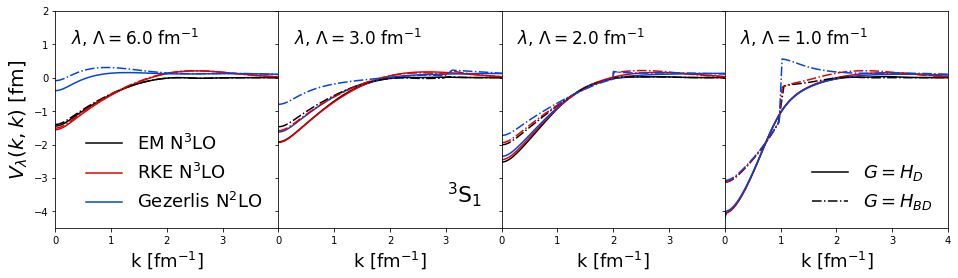

In [7]:
# Plot diagonal and off-diagonal matrix elements of SRG-evolved potentials


# Diagonal matrix elements for the three default SRG-evolved potentials with Wegner and block-diagonal generators 
# 3S1
potential_slices('diag', '3S1', lambda_array_slices, em_n3lo, rke_n3lo, gez_n2lo)
# 1S0
potential_slices('diag', '1S0', lambda_array_slices, em_n3lo, rke_n3lo, gez_n2lo)
# 1P1
potential_slices('diag', '1P1', lambda_array_slices, em_n3lo, rke_n3lo, gez_n2lo)


# Far off-diagonal matrix elements for the three default SRG-evolved potentials with Wegner and block-diagonal
# 3S1
potential_slices('off-diag', '3S1', lambda_array_slices, em_n3lo, rke_n3lo, gez_n2lo)
# 1S0
potential_slices('off-diag', '1S0', lambda_array_slices, em_n3lo, rke_n3lo, gez_n2lo)
# 1P1
potential_slices('off-diag', '1P1', lambda_array_slices, em_n3lo, rke_n3lo, gez_n2lo)